In [ ]:
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from tqdm import tqdm

from pointnet_utils import PointNetEncoder, feature_transform_reguliarzer


## Write a Dataset Class to generate Cylinder Dataset, with different poses and augmentations. 



class BarrelNet(nn.Module):
    def __init__(self, k=40, normal_channel=True):
        super(BarrelNet, self).__init__()
        if normal_channel:
            channel = 6
        else:
            channel = 3
        self.feat_normal = PointNetEncoder(global_feat=True, use_Tnet=False, channel=channel)
        self.feat_radius = PointNetEncoder(global_feat=True, use_Tnet=True, channel=channel)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        self.dropout = nn.Dropout(p=0.4)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()

    def forward(self, x):
        xn, _, _ = self.feat_normal(x)
        xr, _, _ = self.feat_radius(x)
        x = (xn + xr)/2# in future make it (xn + xr)/2
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.dropout(self.fc2(x))))
        x = self.fc3(x)
        radius = F.sigmoid(x[:,-1])        
        normal = torch.concatenate([F.tanh(x[:,:2]), F.sigmoid(x[:,2:3])], dim=1)
        normal = normal / torch.linalg.norm(normal, dim=-1, keepdim=True)
        return radius, normal 
    
    

In [ ]:
import trimesh

def create_capped_cylinder(radius, height, sections=32):
    """
    Create a capped cylinder using trimesh.
    
    Args:
        radius (float): Radius of the cylinder.
        height (float): Height of the cylinder.
        sections (int): Number of sections for the cylinder's roundness.
        
    Returns:
        trimesh.Trimesh: A capped cylinder mesh.
    """
    # Create the capped cylinder with cap=True
    capped_cylinder = trimesh.creation.cylinder(radius=radius, height=height, sections=sections, cap=True)
    
    return capped_cylinder

# Example usage
radius = 1.0
height = 4.0
capped_cylinder = create_capped_cylinder(radius, height)

# Visualization (optional)
capped_cylinder.show()

In [ ]:
import os
import torch
import torch.optim as optim
import numpy as np
import roma
from data import generate_cylinder_pts, prepare_point_cloud, normalize_pc, CylinderData
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import Dataset, DataLoader

    
train_data = CylinderData(num_poses=5000)
test_data = CylinderData(num_poses=1000)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

pointnet = BarrelNet(k=4, normal_channel=False).cuda()
pointnet.train()


optimizer = optim.Adam(pointnet.parameters(), lr=0.00005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.9)

def compute_loss(sample, radius_pred, axis_pred, use_radius_loss=False, use_axis_loss=True):
    """ Compute loss on the predictions of pointnet """
    assert use_axis_loss or use_radius_loss, "Atleast one of the losses should be used"
    loss_axis = (1 - F.cosine_similarity(sample['axis_vec'], axis_pred, dim=1)).mean()
    loss_radius = F.mse_loss(radius_pred, sample['radius_gt'] / sample['scale_gt'])
    loss = 0.0 
    if use_radius_loss:
        loss = loss + loss_radius
    if use_axis_loss:
        loss = loss + loss_axis
    return loss

def train(model, train_loader, optimizer, scheduler, num_epochs=10000, save_epoch=1000, save_dir='weights/r0'):
    """ 
    """
    os.makedirs(save_dir, exist_ok=True)
    model.train()  # Set model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        for sample in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            radius_pred, axis_pred = model(sample['pts'])
            loss = compute_loss(sample, radius_pred, axis_pred, use_radius_loss=False, use_axis_loss=True)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Step the scheduler at the end of each epoch
        scheduler.step()
        if epoch % 50 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}, LR: {scheduler.get_last_lr()[0]}')

        if epoch % save_epoch == 0:
            torch.save(pointnet.state_dict(), os.path.join(save_dir, f'pointnet_iter{epoch}.pth'))

train(pointnet, train_loader, optimizer, scheduler)
torch.save(pointnet.state_dict(), 'weights/pointnet.pth')

# # Example usage

# points = generate_cylinder_pts(1.0, 1.0)
# axis = torch.tensor([0.0, 0.0, 1.0])
# points_valid, radius, burial_offset = prepare_point_cloud(points, axis)
# pts, scale = normalize_pc(points_valid)
# point_cloud_np = points.cpu().numpy()
# point_cloud_rotated_np = points_valid.cpu().numpy()

# fig = plt.figure()
# ax1 = fig.add_subplot(121, projection='3d')
# ax1.scatter(point_cloud_np[:, 0], point_cloud_np[:, 1], point_cloud_np[:, 2], s=1)
# ax1.set_title("Original Point Cloud")

# ax2 = fig.add_subplot(122, projection='3d')
# ax2.scatter(point_cloud_rotated_np[:, 0], point_cloud_rotated_np[:, 1], point_cloud_rotated_np[:, 2], s=1)
# ax2.set_title("Rotated Point Cloud")

In [ ]:
from tqdm import tqdm
def test(model, test_loader):
    model.eval()
    running_acc_axis = 0.0
    accs_axis = []
    criterion_cosine = nn.CosineSimilarity(dim=1)
    for sample in tqdm(test_loader):
        with torch.no_grad():
            radius_pred, axis_pred = model(sample['pts'])
            radius_pred = radius_pred * sample['scale_gt'].cuda()
            acc_axis = (1 + criterion_cosine(sample['axis_vec'], axis_pred).mean())/2
            running_acc_axis += acc_axis.item()
            accs_axis.append(acc_axis)
    accs = torch.tensor(accs_axis)
    print(f"Best Accuracy: {torch.max(accs)}")
    print(f"Worst Accuracy: {torch.min(accs)}")
    print(f'Average Accuracy: {running_acc_axis / len(test_loader)}')


test(pointnet, test_loader)


In [106]:

class CustomDepthIntegrator(mi.SamplingIntegrator):
    def __init__(self, props):
        super().__init__(props)

    def sample(self, scene, sampler, ray, medium, aovs, active=True):
        si = scene.ray_intersect(ray, active=True)
        depth = mi.Float(10000.0)  # Large value for depth background
        depth = mi.select(si.is_valid(), si.t, depth)
        return mi.Spectrum(depth), active
    
mi.register_integrator('custom_depth', lambda props: CustomDepthIntegrator(props))

(576, 768, 4)


/tmp/ipykernel_3887460/522246733.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rotation_vector = torch.tensor(rotation_vector, dtype=torch.float32, device=device)
/tmp/ipykernel_3887460/522246733.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  angle = torch.tensor(angle, dtype=torch.float32, device=device)


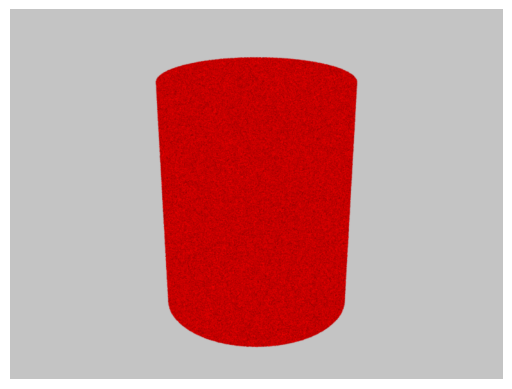

In [3]:
### Creating partially occluded point cloud. 
import mitsuba as mi
import numpy as np 
import roma
import torch
import drjit as dr
from matplotlib import pyplot as plt
os.environ['PYOPENGL_PLATFORM'] = 'egl'

mi.set_variant('cuda_ad_rgb')
import trimesh 

def rotate_to_axis(axis, device='cuda'):
    """
    Rotate the point cloud to align its z-axis with the given axis using PyTorch.
    
    Args:
        axis (torch.Tensor): Target axis to align with, should be of shape (3,).
        device (str): Device to perform the computation ('cpu' or 'cuda').
    Returns:
        torch.Tensor: Rotated point cloud of shape (N, 3).
    """
    ## TODO: make this batched, to rotate the point cloud to different configurations at once. 
    # Normalize the axis
    axis = axis / torch.linalg.norm(axis)
    z_axis = torch.tensor([0., 0., 1.], device='cuda')
    rotation_vector = torch.cross(z_axis, axis)
    angle = torch.arccos(torch.dot(z_axis, axis))
    
    # Convert rotation vector and angle to a PyTorch tensor
    rotation_vector = torch.tensor(rotation_vector, dtype=torch.float32, device=device)
    angle = torch.tensor(angle, dtype=torch.float32, device=device)
    
    # Create the rotation matrix using torch-roma
    rotation_matrix = roma.rotvec_to_rotmat(rotation_vector * angle)
    return rotation_matrix
    
    

## load cylinder mesh in mitsuba 3 
burial_offset = 0.0
capped_cylinder = trimesh.creation.cylinder(radius=1.0, height=2.5, sections=64, cap=True)
axis = torch.tensor([0.,0.,1.0]).cuda()
rotmat = rotate_to_axis(axis).cpu().numpy()
pose = np.eye(4)
pose[:3,:3] = rotmat
pose[2,3] = burial_offset
capped_cylinder.apply_transform(pose)

def get_mi_mesh(_name, _vertex_positions, _triangle_indices, _id):
	
	vertex_pos = mi.TensorXf(_vertex_positions)
	face_indices = mi.TensorXu(_triangle_indices)
	props = mi.Properties()
	bsdf = mi.load_dict({
		'type': 'diffuse',
		'reflectance': {
			'type': 'rgb',
			'value': [1, 0, 0]
			}
		})
	emitter = mi.load_dict({
		'type': 'area',
		'radiance': {
			'type': 'rgb',
			'value': [1, 0, 0],
			}
		})
	props["mesh_bsdf"] = bsdf

	mesh = mi.Mesh(
		_name,
		vertex_count=_vertex_positions.shape[0],
		face_count=_triangle_indices.shape[0],
		has_vertex_normals=False,
		has_vertex_texcoords=False,
		props=props
	)
	mesh_params = mi.traverse(mesh)
	mesh_params["vertex_positions"] = dr.ravel(vertex_pos)
	mesh_params["faces"] = dr.ravel(face_indices)
	mesh_params.update()
	return mesh 

mesh = get_mi_mesh("cylinder", capped_cylinder.vertices, capped_cylinder.faces, 0)
scene = mi.load_dict({
    "type": "scene",
    "integrator": {"type": "aov", "aovs": 'dd.y::depth', "my_image":{'type': 'path'}},
    'sampler': {
        'type': 'independent',
        'sample_count': 256
    },
    "light": {"type": "constant"},
    "sensor": {
        "type": "perspective",
        "to_world": mi.ScalarTransform4f.look_at(
            origin=[0, 7, 3], target=[0, 0, 0], up=[0, 0, 1]
        ),
    },
    "cylinder": mesh,
})
img = mi.render(scene)
depth = img.numpy()[:,:,-1]
img_rgb = img.numpy()[:,:,:3]
depth = 255 * depth / depth.max()
print(img.shape)
plt.axis("off")
plt.imshow(img_rgb/img_rgb.max());



In [133]:
def get_KRT(fov=np.pi/3, HW=[400,400], cam_origin=None, target=None):
	""" Compute K matrix and camera pose from mitsuba3 scene. Returns torch.tensor K (3x3), and RT [4x4]"""
	H, W = HW 
	fx = W / (2 * np.tan(fov/2))
	fy = fx
	cx, cy = W/2, H/2
	K = torch.tensor([[fx, 0.0, cx], [0.0, fy, cy], [0.0, 0.0, 1.0]]).float().cuda()
	# RT = torch.from_numpy(params['sensor.to_world'].matrix.numpy()).float().cuda()[0]
	return K

def pc_from_depth(depthmap, K, cam2world):
    """ Compute point cloud from depthmap and K matrix 
    Args:
		depthmap (torch.tensor) M,N
		K (torch.tensor) [3,3]
		cam2world (torch.tensor) [4,4] pose matrix that goes from camera to world 
    """
    fx, fy, cx, cy = K[0,0], K[1,1], K[0,2], K[1,2]
    y, x = depthmap.shape[:2]
    v, u = torch.meshgrid(torch.arange(y).cuda(), torch.arange(x).cuda(), indexing='ij')
    X = (u - cx) * depthmap / fx 
    Y = (v - cy) * depthmap / fy
    Z = depthmap
    idx = depthmap > 0
    ## Taking the optical pose transformation into account. 
    points = torch.stack([X[idx], -Y[idx], -Z[idx]], dim=-1).reshape(-1,3)
    points = points@cam2world[:3,:3].T + cam2world[:3, 3:].T
    R_z_90 = torch.tensor([[0.0, 1.0, 0.0], [-1.0, 0.0, 0.0], [0.0, 0.0, 1.0]]).cuda()
    points = points @ R_z_90.T
    return points
    
K = get_KRT()
depthmap = render_depth(scene)
points = pc_from_depth(depthmap, K, RT)

AssertionError: 

[[ 0.         -0.70710677 -0.7071068   5.        ]
 [-0.          0.70710677 -0.7071068   5.        ]
 [ 0.99999994  0.          0.          0.        ]
 [ 0.          0.          0.          1.        ]]


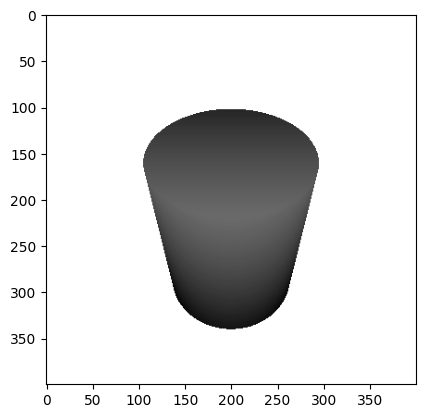

In [135]:
import numpy as np
import trimesh
import pyrender
import matplotlib.pyplot as plt
import mitsuba as mi 
import os 
from pyrender.platforms.osmesa import OSMesaPlatform
pyrender.platform = OSMesaPlatform(400,400)


mesh = pyrender.Mesh.from_trimesh(capped_cylinder)
c2w =mi.Transform4f.look_at(origin=[5,5,0], target=[0,0,0], up=[0,1,0]).matrix.numpy()[0]
print(c2w)


scene = pyrender.Scene()
scene.add(mesh)
camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0, aspectRatio=1.0)
s = np.sqrt(2)/2
camera_pose = np.array([
    [0.0, -s,   s,   3],
    [1.0,  0.0, 0.0, 0.0],
    [0.0,  s,   s,   3.5],
    [0.0,  0.0, 0.0, 1.0]])


scene.add(camera, pose=camera_pose)
light = pyrender.SpotLight(color=np.ones(3), intensity=0.5,
                            innerConeAngle=np.pi/16.0,
                            outerConeAngle=np.pi/6.0)
scene.add(light, pose=camera_pose)

r = pyrender.OffscreenRenderer(400,400)
color, depth = r.render(scene)
plt.figure()
plt.imshow(depth, cmap=plt.cm.gray_r)

In [136]:
pc = pc_from_depth(torch.from_numpy(depth).float().cuda(), K, torch.tensor(camera_pose).float().cuda())

In [137]:
import plotly.graph_objects as go
import numpy as np

# Generate some random 3D data points
np.random.seed(0)
points_np = pc.cpu().numpy()
x, y, z = points_np[:,0], points_np[:,1], points_np[:,2]

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=1,
        color=z,                # Set color to the z values
        colorscale='Viridis',   # Choose a colorscale
        opacity=1.0
    )
)])

# Set the layout
fig.update_layout(
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    ),
    title='3D Point Cloud',
    showlegend=False
)

# Show the plot
fig.show()

In [52]:
c2w =mi.Transform4f.look_at(origin=[3,0,3.5], target=[3.7071,0,4.2071], up=[-0.7071, 0, 0.7071]).matrix.numpy()[0]

[[ 0.        -0.7071068  0.7071068  3.       ]
 [ 1.         0.         0.         0.       ]
 [-0.         0.7071068  0.7071068  3.5      ]
 [ 0.         0.         0.         1.       ]]
